<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/sentiment_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [6]:
df = pd.read_table('/review.txt', names=['ratings', 'reviews'])
df

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


#### 중복 데이터가 있다면 제거

In [7]:
df.drop_duplicates('reviews',keep='first')
df.shape

(200000, 2)

#### 훈련, 테스트셋 분리

In [8]:
train, val = train_test_split(df, test_size = 0.2, random_state = 11)
train.shape, val.shape

((160000, 2), (40000, 2))

In [9]:
val, test = train_test_split(val, test_size = 0.5, random_state = 11)
val.shape, test.shape

((20000, 2), (20000, 2))

#### 별점으로 라벨링 : 별점이 4을 넘으면 긍정 리뷰, 이하는 부정 리뷰로 분류

In [10]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0
  
train['label'] = train['ratings'].apply(star_evaluate)
val['label'] = val['ratings'].apply(star_evaluate)
train

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다. 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 ...,1
62572,4,"가방사이즈 딱 적절해서 좋고, 탄탄한 느낌이라 좋네요. 다만 새것 냄새가 2일째 빠...",1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고..벨브도돌리다밑에캡이빠져버리네여..ㅡㅡ그래서본드로붙였는데..노즐만...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0
...,...,...,...
102327,1,완전 잘깨져요 이건 뭐 잠깐 바닥에 스치기만해도 깨져있어요,0
97617,2,바코드안떳어요,0
21584,2,네조아요. 필요해서 샀어요,0
36543,5,발열 엄청 오래 지속되고 냄새도 없고 만족합니다,1


In [11]:
train['label'].value_counts()

0    80157
1    79843
Name: label, dtype: int64

#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [12]:
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)
train.head()

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0


In [13]:
val['reviews'] = val['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
val['reviews'].replace('', np.nan, inplace=True)
val.head()

,ratings,reviews,label
109140,5,배송빠르고 맘에들어요 재구매예정이요,1
56882,5,재구매 배터리가 오래가네요,1
195983,2,귀퉁이 베어링이 다른거라 무게균형이안맞아서 얼마 안돌아갑니다 불만,0
90903,1,바지 박음질 다 뜯어져서 하루 세탁에 첫날 착용에 제대로 입지 못했어요 바지 박음질...,0
181836,5,신경써서 잘배송해주셨어요 감사해요 이쁘게 잘 쓸게용,1


In [14]:
test['reviews'] = test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['reviews'].replace('', np.nan, inplace=True)
test.head()

,ratings,reviews
87893,4,생각보다 착용시 줄편하네요
121329,5,배송도 빠르구 향도 너무 좋고 무엇보다 사슴이 너무너무 예뻐요 아빠 선물로 드렸는데...
5782,2,배송이 무지 늦어요
124683,2,더운 날씨이긴하나 음식인데 따뜻하게 와서
187665,5,아직 관심은 없는듯 하지만 계속 쥐어주고있어요


#### 토큰화 - Mecab 사용

In [15]:
mecab = Mecab()

In [16]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train['tokenized'] = train['reviews'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
val['tokenized'] = val['reviews'].apply(mecab.morphs)
val['tokenized'] = val['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [19]:
test['tokenized'] = test['reviews'].apply(mecab.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
train.head()

,ratings,reviews,label,tokenized
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1,"[머리, 끝, 많이, 갈라져서, 구매, 했, 습니다, 이미, 갈라진, 건, 어쩔, ..."
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1,"[가방, 사이즈, 딱, 적절, 해서, 좋, 탄탄, 느낌, 라, 좋, 네요, 다만, ..."
102317,2,생각보다 짧아요 ㅠ,0,"[생각, 보다, 짧, 아요, ㅠ]"
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0,"[별로, 따뜻, 않, 벨, 브, 돌리, 밑, 캡, 빠져, 버리, 네여, ㅡㅡ그래서본..."
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0,"[마스크, 소형, 인데, 끈, 이대형, 네요, ㅎ, 그것, 쉽, 끊, 어, 져요, ㅜ]"


In [21]:
test.head()

,ratings,reviews,tokenized
87893,4,생각보다 착용시 줄편하네요,"[생각, 보다, 착, 용시, 줄, 편하, 네요]"
121329,5,배송도 빠르구 향도 너무 좋고 무엇보다 사슴이 너무너무 예뻐요 아빠 선물로 드렸는데...,"[배송, 빠르, 구, 향도, 너무, 좋, 무엇, 보다, 사슴, 너무너무, 예뻐요, ..."
5782,2,배송이 무지 늦어요,"[배송, 무지, 늦, 어요]"
124683,2,더운 날씨이긴하나 음식인데 따뜻하게 와서,"[더운, 날씨, 긴, 하나, 음식, 인데, 따뜻, 와서]"
187665,5,아직 관심은 없는듯 하지만 계속 쥐어주고있어요,"[아직, 관심, 없, 하지만, 계속, 쥐, 어, 주, 있, 어요]"


#### 단어 빈도에 따른 시각화 - Counter, Wordcloud 패키지 이용

In [22]:
negative_words = np.hstack(train[train.label == 0]['tokenized'].values)
positive_words = np.hstack(train[train.label == 1]['tokenized'].values)

In [23]:
nw = Counter(negative_words)
print(nw.most_common(20))

[('네요', 33946), ('는데', 21646), ('안', 21063), ('어요', 15822), ('너무', 14183), ('있', 14107), ('했', 12389), ('좋', 10472), ('배송', 10306), ('같', 9620), ('거', 9467), ('어', 9425), ('구매', 9383), ('아요', 9281), ('없', 9273), ('되', 9097), ('습니다', 9023), ('그냥', 8893), ('잘', 8692), ('않', 8509)]


In [24]:
nwc = nw.most_common(15)

In [25]:
! pip install wordcloud

https://myjamong.tistory.com/48 - wordcloud 참고

{'네요': 33946, '는데': 21646, '안': 21063, '어요': 15822, '너무': 14183, '있': 14107, '했': 12389, '좋': 10472, '배송': 10306, '같': 9620, '거': 9467, '어': 9425, '구매': 9383, '아요': 9281, '없': 9273}


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


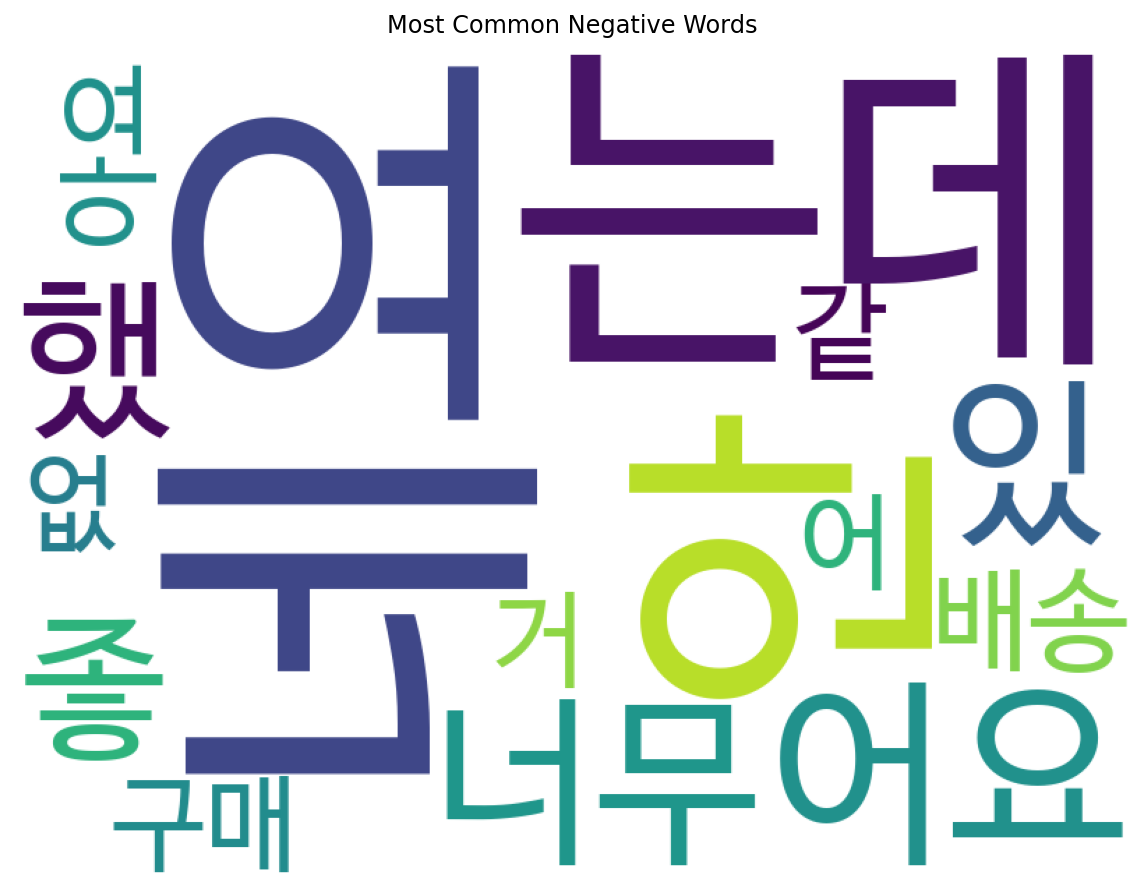

In [26]:
from wordcloud import WordCloud

#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정
negative_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(nwc))
cloud = negative_word_cloud.generate_from_frequencies(dict(nwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Negative Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [27]:
pw = Counter(positive_words)
print(pw.most_common(20))

[('좋', 42133), ('아요', 22433), ('네요', 21289), ('어요', 19862), ('잘', 19824), ('구매', 17280), ('습니다', 14421), ('있', 13208), ('배송', 12925), ('는데', 12389), ('합니다', 10439), ('했', 10437), ('먹', 10389), ('재', 9918), ('너무', 8986), ('같', 8464), ('만족', 7708), ('거', 6937), ('어', 6741), ('기', 6624)]


In [28]:
pwc = pw.most_common(15)

{'좋': 42133, '아요': 22433, '네요': 21289, '어요': 19862, '잘': 19824, '구매': 17280, '습니다': 14421, '있': 13208, '배송': 12925, '는데': 12389, '합니다': 10439, '했': 10437, '먹': 10389, '재': 9918, '너무': 8986}


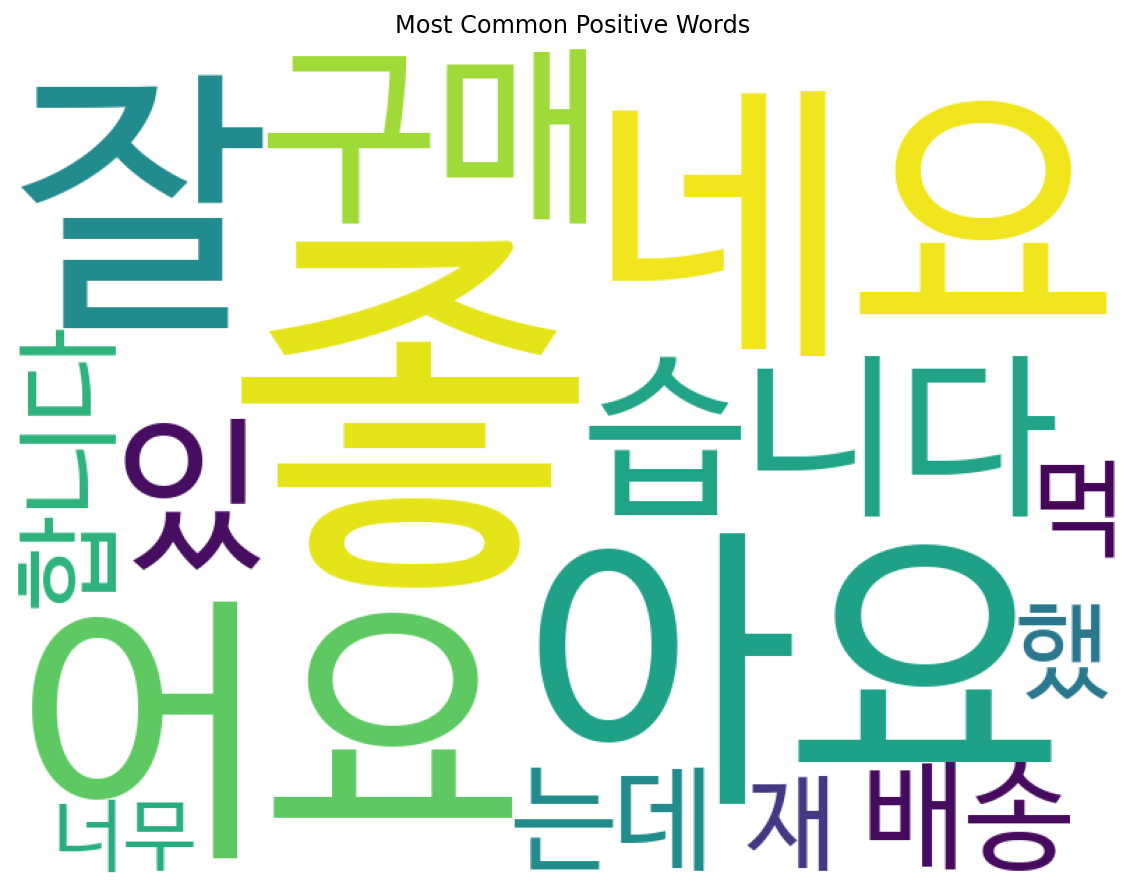

In [29]:
positive_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(pwc))
cloud = positive_word_cloud.generate_from_frequencies(dict(pwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Positive Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

#### 데이터에 정수 인코딩

In [30]:
X_train = train['tokenized'].values
y_train = train['label'].values
X_val= val['tokenized'].values
y_val = val['label'].values
X_test = test['tokenized'].values

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)

In [32]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



단어 집합(vocabulary)의 크기 : 4
등장 빈도가 1번 이하인 희귀 단어의 수: 4
단어 집합에서 희귀 단어의 비율: 100.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 100.0


In [33]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2


In [34]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.22526875


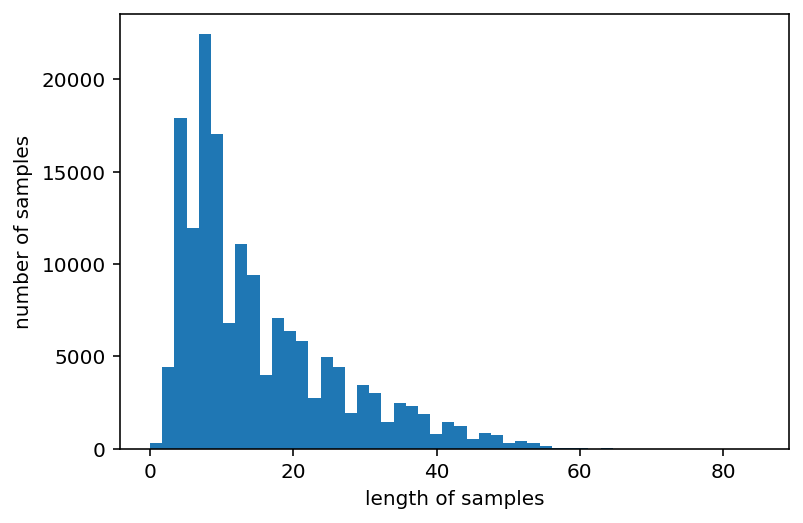

In [35]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#### GRU 모델을 이용한 감성 분석

In [37]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         200       
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 88,649
Trainable params: 88,649
Non-trainable params: 0
_________________________________________________________________


In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [40]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2134/2134 [==============================] - 27s 9ms/step - loss: 0.6802 - acc: 0.5692 - val_loss: 0.6763 - val_acc: 0.5774

Epoch 00001: val_acc improved from -inf to 0.57744, saving model to best_model.h5
Epoch 2/15
2134/2134 [==============================] - 19s 9ms/step - loss: 0.6789 - acc: 0.5725 - val_loss: 0.6766 - val_acc: 0.5745

Epoch 00002: val_acc did not improve from 0.57744
Epoch 3/15
2134/2134 [==============================] - 19s 9ms/step - loss: 0.6787 - acc: 0.5729 - val_loss: 0.6747 - val_acc: 0.5778

Epoch 00003: val_acc improved from 0.57744 to 0.57781, saving model to best_model.h5
Epoch 4/15
2134/2134 [==============================] - 19s 9ms/step - loss: 0.6785 - acc: 0.5729 - val_loss: 0.6762 - val_acc: 0.5763

Epoch 00004: val_acc did not improve from 0.57781
Epoch 5/15
2134/2134 [==============================] - 19s 9ms/step - loss: 0.6783 - acc: 0.5732 - val_loss: 0.6757 - val_acc: 0.5791

Epoch 00005: val_acc improved from 0.57781 to 0.57912

#### BiLSTM 모델을 이용한 감성 분석

In [43]:
from tensorflow.keras.layers import LSTM, Bidirectional

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100))
model_lstm.add(Bidirectional(LSTM(100)))
model_lstm.add(Dense(1, activation='sigmoid'))

In [44]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         200       
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,201
Trainable params: 161,201
Non-trainable params: 0
_________________________________________________________________


In [45]:
es_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_lstm = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [46]:
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
500/500 [==============================] - 8s 14ms/step - loss: 0.6775 - acc: 0.5745 - val_loss: 0.6743 - val_acc: 0.5792

Epoch 00001: val_acc did not improve from 0.57953
Epoch 2/15
500/500 [==============================] - 6s 13ms/step - loss: 0.6775 - acc: 0.5740 - val_loss: 0.6743 - val_acc: 0.5796

Epoch 00002: val_acc improved from 0.57953 to 0.57956, saving model to best_model.h5
Epoch 3/15
500/500 [==============================] - 6s 13ms/step - loss: 0.6774 - acc: 0.5747 - val_loss: 0.6752 - val_acc: 0.5796

Epoch 00003: val_acc did not improve from 0.57956
Epoch 4/15
500/500 [==============================] - 6s 13ms/step - loss: 0.6775 - acc: 0.5740 - val_loss: 0.6745 - val_acc: 0.5796

Epoch 00004: val_acc did not improve from 0.57956
Epoch 5/15
500/500 [==============================] - 7s 13ms/step - loss: 0.6775 - acc: 0.5744 - val_loss: 0.6749 - val_acc: 0.5796

Epoch 00005: val_acc did not improve from 0.57956
Epoch 6/15
500/500 [=========================